In [1]:
# !pip3 install two-sample-binomial
# !pip3 install multiple-hypothesis-testing

from multitest import MultiTest

import numpy as np
import scipy

import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams['figure.figsize'] =  [8, 6]
mpl.style.use('ggplot')
%matplotlib inline
from tqdm import tqdm
import pandas as pd

from survival import *

from test_gene_expression import reduce_time_resolution
from illustrate_gene_expression_survival_curves import illustrate_survival_curve_time2event

## Load raw data:

In [2]:
df = pd.read_csv("./Data/SCANB_groups_valid.csv")
gene_names = [c for c in df.columns if c not in ['Unnamed: 0', 'time', 'event']]

div_probs = df.agg(['mean'])
thresh = 0.001
valid_genes = [g for g in gene_names if np.abs(div_probs[g]['mean'] - 0.5) < thresh]
invalid_genes = [g for g in gene_names if np.abs(div_probs[g]['mean'] - 0.5) > thresh]
df = df.drop(columns = invalid_genes + ['Unnamed: 0'])

assert(len(invalid_genes) == 0)

print("Removed: ", 9259 - len(valid_genes))

Removed:  557


### Ilustrate data raw data

HERE (5/9/2023):
 - finish survival curve with lifeline
 - check what is the issue with our implementation

(0.7, 1.01)

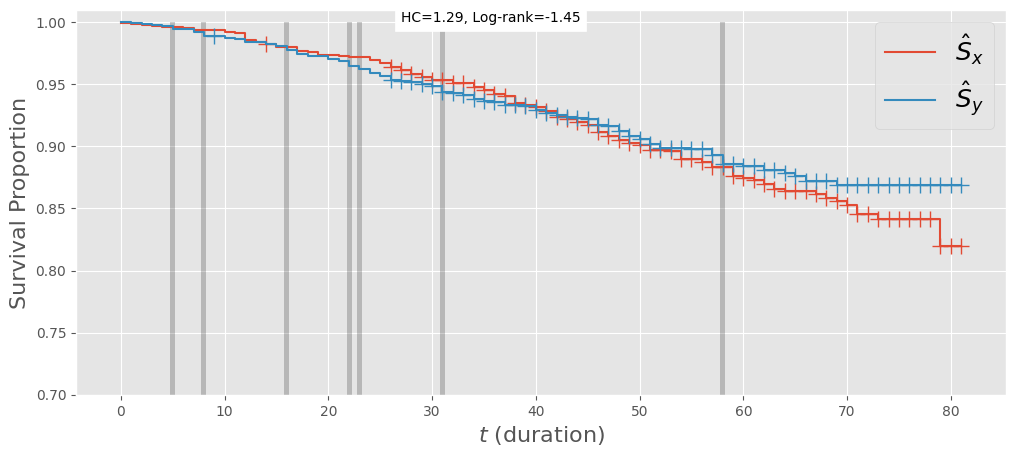

In [3]:
plt.rcParams['figure.figsize'] =  [12, 5]

gene_name = 'IFNAR2'

df_gene = df.filter([gene_name, 'time', 'event'])
df_gene_T = reduce_time_resolution(df_gene, T=82)
illustrate_survival_curve_time2event(df_gene_T.rename(columns={gene_name : 'group'}))
plt.ylim([0.7,1.01])

## Read and report null values

In [4]:
def infmean(x):
    "mean ignoring inf values"
    return np.mean(np.ma.masked_invalid(x))

def std_95(x):
    return scipy.stats.mstats.mjci(x, prob = [0.95])[0]

def q95(x):
    """
    Compute the 95-th percentile of the vector x
    """
    if x.dtypes.kind == 'O':
        return np.nan
    else:
        return pd.Series.quantile(x, .95)

def q99(x):
    """
    Compute the 95-th percentile of the vector x
    """
    if x.dtypes.kind == 'O':
        return np.nan
    else:
        return pd.Series.quantile(x, .99)


def infstd(x):
    return np.std(np.ma.masked_invalid(x))


In [43]:
T = 82
M = 1
stbl = True
df0 = pd.read_csv("results/SCANB_null_True_T82_rep1.csv")
#df0 = pd.read_csv("results/SCANB_null_True_T100.csv")
#df0 = pd.read_csv(f'results/SCANB_null_{stbl}_T{T}.csv')
a = df0.filter(['hc_greater', 'log_rank_greater', 'log_rank_pval_greater', 'hc_greater_rev', 'logrank_lifelines_None']).agg(['mean','std',q95, q99])
crit_vals = a.loc['q99'].to_dict()
a

,hc_greater,log_rank_greater,log_rank_pval_greater,hc_greater_rev,logrank_lifelines_None
mean,-0.918802,-0.000779,0.500085,-0.918091,0.652581
std,1.157988,0.808570,0.254423,1.159438,0.922842
q95,0.744470,1.329086,0.907905,0.745094,2.507596
q99,1.008734,1.877523,0.969805,1.008734,4.349673


In [41]:
output_dir = "/Users/kipnisal/Dropbox/Apps/Overleaf/Survival Analysis with Sensitivity to Possible Rare and Weak Differences/"
#output_dir = "./"

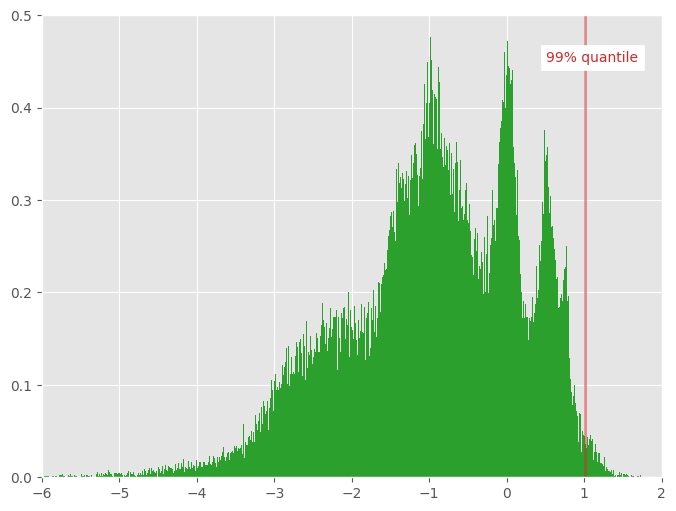

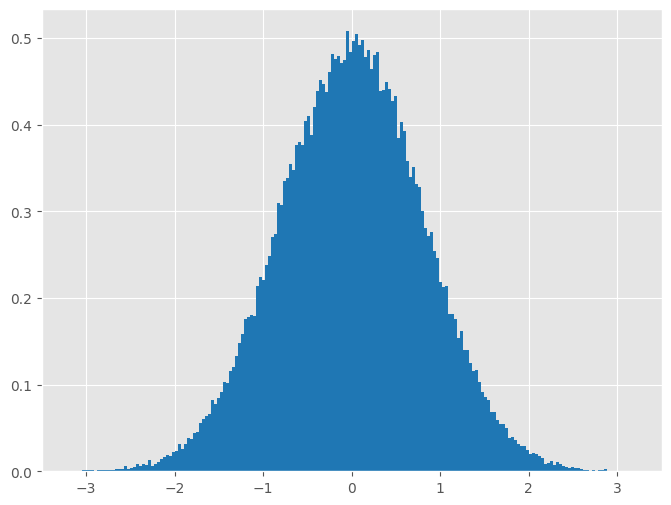

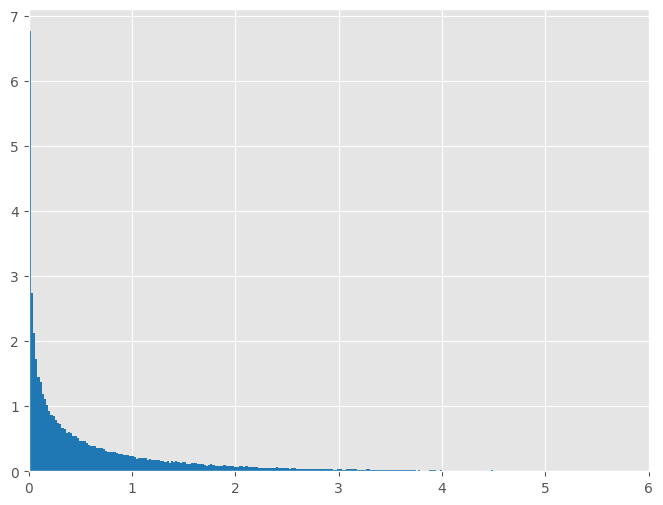

In [96]:
vals = list(df0.hc_greater)
plt.hist(vals, bins = np.linspace(-6,3,1011), density=True, color='tab:green')
plt.rcParams['figure.figsize'] =  [8, 6]
plt.xlim([-6, 2])
plt.ylim([0, 0.5])
plt.vlines(crit_vals['hc_greater'], 0, 1, linewidth=2, color='tab:red', alpha=0.5, label='99% quantile')
plt.text(crit_vals['hc_greater'] - 0.5, 0.45, "99% quantile", color='tab:red', backgroundcolor='white')

plt.savefig(output_dir + f'Figs/hc_hist_T{T}.png')
plt.show()

vals = list(df0.log_rank_greater) 
plt.hist(vals, bins = np.linspace(-4,4,237), density=True, color='tab:blue')
plt.rcParams['figure.figsize'] =  [8, 6]
plt.xlim([-3.5, 3.5])

plt.savefig(output_dir + 'Figs/lr_hist.png')
plt.show()

vals = list(df0.logrank_lifelines_None) 
plt.hist(vals, bins = np.linspace(0,5,237), density=True, color='tab:blue')
plt.rcParams['figure.figsize'] =  [8, 6]
plt.xlim([0, 6])

plt.savefig(output_dir + 'Figs/lr_chisq_hist.png')
plt.show()

## Analyze Results

Use script in ``test_gene_expression.py`` to get the results

In [9]:
result_file = "results/SCANB_True_T82.csv"
null_file = "results/SCANB_null_True_T82_rep10.csv"

res = pd.read_csv(result_file)
df0 = pd.read_csv(null_file)

In [10]:
df0.agg([q95, q99])

,Unnamed: 0,log_rank_greater,log_rank_pval_greater,hc_greater,fisher_greater,min_p_greater,berk_jones_greater,logrank_lifelines_None,logrank_lifelines_wilcoxon,logrank_lifelines_tarone-ware,...,fisher_greater_rev,min_p_greater_rev,berk_jones_greater_rev,logrank_lifelines_None_rev,logrank_lifelines_wilcoxon_rev,logrank_lifelines_tarone-ware_rev,logrank_lifelines_peto_rev,logrank_lifelines_fleming-harrington_rev,name_rev,itr
q95,0.0,1.335024,0.908692,0.754745,105.174177,5.126614,14.472991,2.533163,3.268845,2.796070,...,105.331135,5.099072,14.657619,2.519691,3.272764,2.800716,2.564193,2.563809,NaN,9499.05
q99,0.0,1.917170,0.970285,1.013695,173.125218,46.051702,46.051702,4.427475,5.540179,4.889679,...,175.452528,46.051702,46.051702,4.412878,5.581884,4.858387,4.377017,4.392755,NaN,9899.01


In [33]:
stats = ['hc_greater', 'hc_greater_rev', 'log_rank_greater', 'log_rank_greater_rev',
         'logrank_lifelines_None', 'logrank_lifelines_None_rev',
        'logrank_lifelines_wilcoxon', 'logrank_lifelines_wilcoxon_rev',
        'logrank_lifelines_tarone-ware', 'logrank_lifelines_tarone-ware_rev',
        'logrank_lifelines_peto', 'logrank_lifelines_peto_rev',
        'logrank_lifelines_fleming-harrington', 'logrank_lifelines_fleming-harrington_rev'
        ]

stats_disp = ['hc_greater', 'log_rank_greater',
         'logrank_lifelines_None',
        'logrank_lifelines_wilcoxon',
        'logrank_lifelines_tarone-ware',
        'logrank_lifelines_peto',
        'logrank_lifelines_fleming-harrington'
        ]


def find_pvalues_of_stats_results(df1, df0, stat_name):
    val0 =df0[stat_name]
    def stat0(x):
        return np.mean(val0 > x)

    return df1[stat_name].apply(stat0)

#df0['log_rank_greater'] = np.random.randn(len(df0))
#df0['log_rank_greater_rev'] = np.random.randn(len(df0))

sig_level = 0.01
for stat_name in stats:
    res.loc[:, stat_name + '_pvalue'] = find_pvalues_of_stats_results(res, df0, stat_name)
    
pvals = res.groupby('name')['hc_greater_pvalue'].mean()

pvals_sig = pvals[pvals < sig_level]
len(pvals_sig)

324

In [12]:
for sig_level in [0.05, 0.01, 0.001, 0.0001]:
    print("Sig = ", sig_level)
    print("Total LR dicoveries: ", np.sum((res['log_rank_greater_pvalue'] <= sig_level) | (res['log_rank_greater_rev_pvalue'] <= sig_level)))
    print("Total LR lifelines dicoveries: ", np.sum((res['logrank_lifelines_None_pvalue'] <= sig_level) | (res['logrank_lifelines_None_rev_pvalue'] <= sig_level)))
    print("Total HC dicoveries: ",np.sum((res['hc_greater_pvalue'] <= sig_level) | (res['hc_greater_rev_pvalue'] <= sig_level)))

# HC discoveries
# 0.05: 1955
# 0.01: 806
# 0.001: 229
# 0.0001: 102

Sig =  0.05
Total LR dicoveries:  4448
Total LR lifelines dicoveries:  3900
Total HC dicoveries:  1955
Sig =  0.01
Total LR dicoveries:  2999
Total LR lifelines dicoveries:  2688
Total HC dicoveries:  806
Sig =  0.001
Total LR dicoveries:  1692
Total LR lifelines dicoveries:  1497
Total HC dicoveries:  229
Sig =  0.0001
Total LR dicoveries:  1105
Total LR lifelines dicoveries:  1156
Total HC dicoveries:  102


In [13]:
sig_level = 0.01

stat = 'log_rank_greater'
#stat = 'logrank_lifelines_None'
#stat = 'logrank_lifelines_wilcoxon'
#stat = 'logrank_lifelines_fleming-harrington'
#stat = 'logrank_lifelines_peto'

ll_stats = ['logrank_lifelines_None','logrank_lifelines_tarone-ware', 'logrank_lifelines_peto', 'logrank_lifelines_wilcoxon', 'logrank_lifelines_fleming-harrington']

if stat in ll_stats:
    sym_stat = True
    print("Warnning: The statistic is symmetric so it cannot find strictly one-sided effects")

log_rank_non = (res[f'{stat}_pvalue'] > sig_level) & (res[f'{stat}_rev_pvalue'] > sig_level)
log_rank_1side_strict = (res[f'{stat}_pvalue'] <= sig_level) & (res[f'{stat}_rev_pvalue'] > sig_level)
log_rank_1side_strict_rev = (res[f'{stat}_pvalue'] > sig_level) & (res[f'{stat}_rev_pvalue'] <= sig_level)
log_rank_2side = (res[f'{stat}_pvalue'] <= sig_level) | (res[f'{stat}_rev_pvalue'] <= sig_level)

log_rank_strict = log_rank_1side_strict | log_rank_1side_strict_rev

hc_non = (res['hc_greater_pvalue'] > sig_level) & (res['hc_greater_rev_pvalue'] > sig_level)
hc_1side_strict = (res['hc_greater_pvalue'] <= sig_level) & (res['hc_greater_rev_pvalue'] > sig_level)
hc_1side_strict_rev = (res['hc_greater_pvalue'] > sig_level) & (res['hc_greater_rev_pvalue'] <= sig_level)
hc_2side = (res['hc_greater_pvalue'] <= sig_level) | (res['hc_greater_rev_pvalue'] <= sig_level)

hc_strict = hc_1side_strict | hc_1side_strict_rev

print("Strictly one-sided effect:")
print("\tDiscoverable by HC: ", np.sum(hc_strict))
print(f"\tDiscoverable by {stat}: ", np.sum(log_rank_strict))

print(f"\tDiscoverable by HC and {stat}: ", np.sum(hc_strict & log_rank_strict))
print(f"\tDiscoverable by HC but not {stat}: ", np.sum(hc_strict & (1 - log_rank_strict) )   )
print(f"\tDiscoverable by {stat} but not HC: ", np.sum((1 - hc_strict) & ( log_rank_strict) )   )
print(f"\tDiscoverable by neigher HC nor {stat}: ", np.sum((1 - hc_strict) & (1 - log_rank_strict) )   )

print(" Either side effect:")

print("\tDiscoverable by HC: ", np.sum(hc_2side))
print(f"\tDiscoverable by {stat}: ", np.sum(log_rank_2side))


print(f"\tDiscoverable by HC and {stat}: ", np.sum(hc_2side & log_rank_2side) )
print(f"\tDiscoverable by HC but not {stat}: ", np.sum(hc_2side & (1 - log_rank_2side)) )
print(f"\tDiscoverable by {stat} but not HC: ", np.sum((1 - hc_2side) & ( log_rank_2side)) )
print(f"\tDiscoverable by neigher HC nor {stat}: ", np.sum((1 - hc_2side) & (1 - log_rank_2side)) )

# all stats except HC
all_two_sided = np.array([False] * len(res))
for stat in ll_stats + ['log_rank_greater', 'log_rank_greater_rev']:   
    all_two_sided  = all_two_sided | (res[f'{stat}_pvalue'] <= sig_level)

only_hc = hc_2side & (1-all_two_sided)
print("Either side effect:")
print("\tDiscoverable by HC but not by any other: ", np.sum(only_hc))

Strictly one-sided effect:
	Discoverable by HC:  797
	Discoverable by log_rank_greater:  2999
	Discoverable by HC and log_rank_greater:  565
	Discoverable by HC but not log_rank_greater:  232
	Discoverable by log_rank_greater but not HC:  2434
	Discoverable by neigher HC nor log_rank_greater:  5471
 Either side effect:
	Discoverable by HC:  806
	Discoverable by log_rank_greater:  2999
	Discoverable by HC and log_rank_greater:  569
	Discoverable by HC but not log_rank_greater:  237
	Discoverable by log_rank_greater but not HC:  2430
	Discoverable by neigher HC nor log_rank_greater:  5466
Either side effect:
	Discoverable by HC but not by any other:  144


### Arrange Results for presentation:

In [14]:
res['hc_pval'] = np.minimum(res['hc_greater_pvalue'], res['hc_greater_rev_pvalue'])
res['log_rank_pval'] = np.minimum(res['log_rank_greater_pvalue'], res['log_rank_greater_rev_pvalue'])
res['l-ratio'] = res['hc_pval'] / res['log_rank_pval']

In [21]:
# take only those discovered by HC but not any other
resi = res[hc_strict & only_hc].sort_values('l-ratio')
len(resi)
resi.tail(n=20).name.values

array(['ERGIC2', 'PNMT', 'EGFL7', 'POU5F1', 'KPNB1', 'VAPB', 'ADNP',
       'CPVL', 'SLCO4A1', 'HEATR1', 'CTBP1', 'POLB', 'C12orf29', 'DDX54',
       'RASSF4', 'HYAL4', 'XAB2', 'RPS7', 'EI24', 'UCHL5'], dtype=object)

In [101]:
def prepare_for_display(resi):
    flip_idc = resi['hc_greater'] < resi['hc_greater_rev']
    resi['flip'] = '$>$ med'
    resi.loc[flip_idc, 'flip'] = '$<$ med'
    resi['hc'] = np.maximum(resi['hc_greater'], resi['hc_greater_rev'])
    resi['log_rank'] = np.maximum(resi['log_rank_greater'], resi['log_rank_greater_rev'])
    rr = resi.reset_index().filter(['name', 'hc', 'hc_pval', 'log_rank', 'log_rank_pval', 'flip'])
    return rr

resi_disp = prepare_for_display(resi)

ls = resi_disp.name.head(40).tolist()
print("Num = ", len(ls))
ls


Num =  40


['DHX32',
 'PBX1',
 'UPF1',
 'TMCO1',
 'HDGF',
 'SLCO3A1',
 'EMILIN2',
 'MAU2',
 'AKT2',
 'DDX5',
 'ATF6',
 'ZNF574',
 'RARRES1',
 'EPB41L4B',
 'AGT',
 'SEC22A',
 'NSF',
 'MICAL1',
 'CAPN9',
 'DHTKD1',
 'SSR2',
 'BCL2L1',
 'IL17RA',
 'BAIAP2',
 'DCAF6',
 'SLC5A12',
 'EGFL8',
 'TOR1AIP2',
 'RIPK4',
 'LEFTY1',
 'MNS1',
 'CNPPD1',
 'SLC39A1',
 'HFE',
 'CYTH1',
 'GRB14',
 'ANKLE2',
 'GFRA3',
 'CNTN2',
 'QRSL1']

#### Illustrate gene and intervals of excessive hazard

/var/folders/3n/c1thdb3136qc3c_4t5br9r6c0000gq/T/ipykernel_87062/3646823195.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  r = resi[res.name == gene_name]


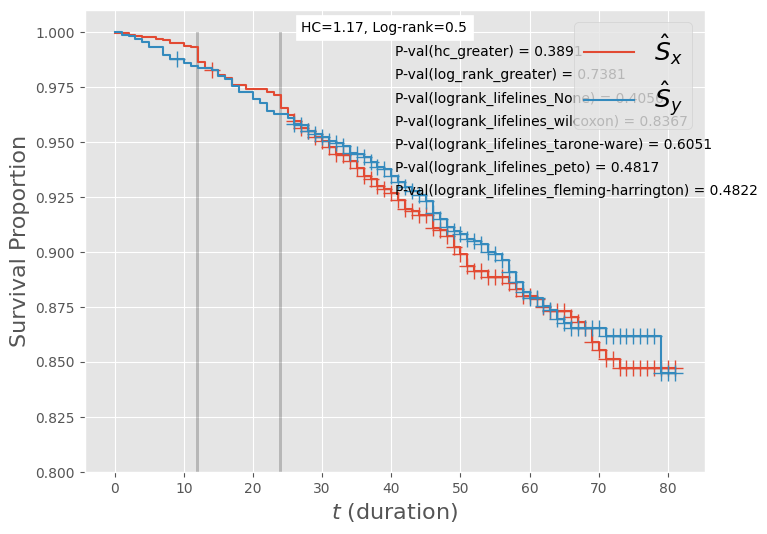

In [108]:
from illustrate_gene_expression_survival_curves import illustrate_survival_curve_time2event

gene_name = 'CYTH1'
T = 82

df_gene = df.filter([gene_name, 'time', 'event'])
df_gene_T = reduce_time_resolution(df_gene, T=82)
#_, dfp = illustrate_survival_curve_time2event(df_gene_T.rename(columns={gene_name : 'group'}), show_stats_in_title=False)
_, dfp = illustrate_survival_curve_time2event(df_gene_T.rename(columns={gene_name : 'group'}),
 show_stats_in_title=True, flip_sides=True)
plt.ylim([0.8,1.01])

acc = 0
for stat in stats_disp:
    r = resi[res.name == gene_name]
    plt.text(0.5, 0.9 - acc, f"P-val({stat}) = {r[stat + '_pvalue'].values[0]}", transform=plt.gca().transAxes)
    acc += 0.05

plt.savefig(f"{output_dir}Figs/{gene_name}.png")
dfp.index.name = 'time'
dfp.filter(['at_risk X', 'at_risk Y', 'events X', 'events Y', 'pvalue'])\
    .to_csv(output_dir + "csv/" + f'{gene_name}.csv')


## To do (6/9/2023):

Fix HCHG_survival_analysis to obtain all information in a single shot


In [33]:
gene_name = 'TRPS1'
T = 82

from test_gene_expression import reduce_time_resolution, two_groups_gene
from survival import multi_pvals

dfg = reduce_time_resolution(two_groups_gene(df, gene_name), T)
Nt1, Nt2 = dfg['at_risk:0'].values, dfg['at_risk:1'].values
Ot1, Ot2 = dfg['observed:0'].values, dfg['observed:1'].values

def HCHG_survival_analysis(Nt1, Nt2, Ot1, Ot2, randomize=False, stbl=stbl):

    pvals = multi_pvals(Nt1, Nt2, Ot1, Ot2, randomize=randomize)
    mt = MultiTest(pvals[pvals<1], stbl=stbl) 
    hc, hct = mt.hc(gamma=.2)
    fisher = mt.fisher()
        
    fpval = pvals <= hct
    
    dfg['pvalue'] = pvals
    dfg['t'] = np.arange(0,len(Ot1))

    cumc1 = dfg['censored:0'].cumsum()
    cumc2 = dfg['censored:1'].cumsum()
    dfg['Survival Proportion X'] = (dfg['at_risk:0'] - dfg['censored:0']) / (dfg['at_risk:0'].max() - cumc1)
    dfg['Survival Proportion Y'] = (dfg['at_risk:1'] - dfg['censored:1']) / (dfg['at_risk:1'].max() - cumc2)
        
    dfg['suspected'] = fpval
    return dfg.set_index('t'), hc, fisher[0]

def HCHG_survival_analysis_full(Nt1, Nt2, Ot1, Ot2, randomize=False, stbl=stbl):
    
    dfg, hc, fisher = HCHG_survival_analysis(Nt1, Nt2, Ot1, Ot2, randomize=randomize, stbl=stbl)
    
    fpval = dfg.suspected
    plt.step(dfg.index, dfg['Survival Proportion X'], 'b', where='pre')
    plt.step(dfg.index, dfg['Survival Proportion Y'], 'r', where='pre')
    ct1 = dfg['censored:0'] > 0
    ct2 = dfg['censored:1'] > 0
    s1 = 10 * (dfg.loc[ct1, 'censored:0'].max() / dfg.loc[ct1, 'censored:0']).values
    s2 = 10 * (dfg.loc[ct2, 'censored:1'].max() / dfg.loc[ct2, 'censored:1']).values
    plt.scatter(dfg.index[ct1], dfg.loc[ct1,'Survival Proportion X'],
                marker='+', c='b',
                s=s1, alpha=.5)
    plt.scatter(dfg.index[ct2], dfg.loc[ct2,'Survival Proportion Y'],
                marker='+', c='r',
                s=s2, alpha=.5)
    
    plt.legend([r'$\hat{S}_x$', r'$\hat{S}_y$'], fontsize=16, loc=1)
    
    plt.bar(dfg.index[:len(fpval)], fpval, color='k', alpha=.2, width=.5)

    plt.title(rf"{gene_name}: HCHG={np.round(hc,3)}, Fisher={np.round(fisher,3)}")
    plt.ylabel('Survival Proportion', fontsize=16)
    plt.xlabel(r'$t$ (Time)', fontsize=16)
    plt.ylim([0.7, 1.01])
    
    return dfg
    
dfg = HCHG_survival_analysis_full(Nt1, Nt2, Ot1, Ot2)
dfp

ImportError: cannot import name 'two_groups_gene' from 'test_gene_expression' (/Users/kipnisal/survival/test_gene_expression.py)

In [163]:
plt.rcParams['figure.figsize'] =  [12, 6]
plt.rcParams["figure.dpi"] = 200

list_to_plot = resi_disp.name.values
list_to_plot = ['TRPS1']

for gene_name in list_to_plot:
    df_disp, dfp = illustrate_survival_curve(df, df0, gene_name, T, stbl=True)
    plt.savefig(output_dir + "Figs/"  + gene_name + ".png")
    plt.show()

    dfd = df_disp.copy()
    dfd = dfd.iloc[:, :-2]

    for tag in ['pvalue', 'pvalue_rev']:
        dfd[tag] = np.round(dfd[tag],3)

    for tag in ['at_risk X', 'at_risk Y', 'events X', 'events Y']:
        dfd[tag] = dfd[tag].astype(int)

    dfd.index.name = 'time'
    dfd.filter(['at_risk X', 'at_risk Y', 'events X', 'events Y', 'pvalue', 'pvalue_rev'])\
        .to_csv(output_dir + "csv/" + f'{gene_name}.csv')


NameError: name 'resi_disp' is not defined

## Randomized P-values

In [375]:
resm = pd.read_csv("SCANB_True_T100_randomized_rep100.csv")

def rate_succ(xx):
    t = 1.41
    return np.mean(xx > t)

def pval_binom(x, n, p=sig_level):
    return np.binom.sf(x, n=100, p=p)

hc_sum = resm.groupby('name').hc_greater.agg(['mean', q95, rate_succ, 'count'])
hc_sum.sort_values('rate_succ', ascending=False).apply(pval_binom() )

,mean,q95,rate_succ,count
name,,,,
MTR,2.142463,2.672658,0.99,100
TRPS1,2.181579,2.805051,0.96,100
C11orf68,1.988362,2.613434,0.94,100
HIST1H4A,1.934908,2.484923,0.93,100
FBXL12,1.940221,2.612060,0.92,100
...,...,...,...,...
COX7C,0.379212,1.285728,0.00,100
DEDD,-0.035174,0.900712,0.00,100
LSS,0.096871,0.955187,0.00,100
